In [14]:
# Como parte de uma PoC sobre LLMs aplicadas a tarefas específicas, estou analisando, constrindo e testando código, 
# bibliotecas e ferramentas que possam permitir a analise de anomalias em logs de aplicações e sistemas.  

In [14]:
# se trabalha ou estuda ML, deve saber da revolução que a proposta apresentada em 
# "Attention Is All You Need" (https://arxiv.org/abs/1706.03762) trouxe para a área
# e de como isso possibilitou um nova era de Deep Learning, com o surgimento de modelos
# SOTA (estado da arte) como GPT, BERT, T5, LLaMa, etc.
# LLMs são treinadas com um grande (massivo!) corpus de dados de texto, como artigos, livros e sites.

In [15]:
# nesse estudo, vamos focar na porção encoder da arquitetura transformers, utilizando uma implementaçao em pytorch;
# a porção encoder do Transformers é excelente para "entender" textos, enquanto a porção decoder é excelente para
# gerar texto;
# um exemplo de LLMs geradas apenas com a porção encoder são as da família BERT (Bidirectional Encoder Representations from Transformers);
# esse notebook não pretende entrar no detalhe de como Transformers, autoencoder e autoregressive LLMs funcionam;
# se você precisa mais orientação ou está começando, o site https://huggingface.co/ é o uma excelente dica para adquirir conhecimento.

#### Esse notebook contem minhas anotações sobre o estudo apresentado em "LogBERT: Log Anomaly Detection via BERT" (publicado em https://arxiv.org/abs/2103.04475)

##### 1 - Descrição dos arquivos fonte e dados usandos nessa PoC:

In [17]:
# você pode usar o código fonte criado pelos pesquisadores do "LogBERT".
# eu usei como base para meu estudo e fiz pequenas alterações (todas relacionadas ao meu estudo).
# na lista a seguir, o codigo fonte importante nessa experiência são:
# - init.sh (criação de diretorios para os outputs);
# - data_process.py (pre-processamento);
# - poc.py (treino e inference) 

In [15]:
!ls -l

total 44
-rw-rw-r-- 1 caf caf  5098 Jul 29 12:14 data_process.py
-rwxrwxr-x 1 caf caf   185 Jul 27 16:59 init.sh
-rw-rw-r-- 1 caf caf 16613 Jul 29 16:37 log_analysis_POC.ipynb
-rw-rw-r-- 1 caf caf  3433 Jul 27 16:59 poc.py
-rw-rw-r-- 1 caf caf   119 Jul 27 17:12 README.md
-rwxrwxr-x 1 caf caf   316 Jul 27 16:59 setenv.sh


In [13]:
# eu usei um log produzido pelo hadoop como exemplo (o arquivo foi baixado de um repo publico)
# acompanhando o arquivo de log (HDFS.log) existe um arquivo contendo a relação de blocks que 
# são considerados "normal" e "abnormal" (o arquivo não será usado no treino, mas sim para o 
# estagio de pre-processamento, aonde criaremos a base de dados usada no treino, que serão 
# apenas os dados de alta-qualiade, ou seja, o que for "normal";
# esse approach é interessante é coincide com o momento atual, aonde varios outros experimentos
# estão sendo propostos, no impacto da qualidade de dados para o deep lerning na criação de LLMs
# para tarefas específicas (e com isso tamanho e custo de processamento muito menor), com resultados
# similares a LLMs consideradas estado da arte. 
# como exemplo, recomento a leitura do estudo https://arxiv.org/abs/2306.11644 ("Textbooks Are All You Need") e também o
# https://arxiv.org/abs/2305.07759 ("TinyStories: How Small Can Language Models Be and Still Speak Coherent English?")

In [1]:
!tree ~/.dataset

/home/caf/.dataset
└── hdfs
    ├── anomaly_label.csv
    └── HDFS.log

1 directory, 2 files


In [ ]:
# uma breve lista do conteúdo do arquivo de log (util para se verificar o formato): 

In [2]:
!head ~/.dataset/hdfs/HDFS.log

081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6
081109 203519 145 INFO dfs.DataNode$PacketResponder: Receiv

In [23]:
# uma breve lista do conteúdo do arquivo de labels:
# (novamente, o arquivo apenas será usado para classificar o que é considerado como "log normal", ou seja 
# para que seja possível que o modelo aprenda corretamenta a "gramática", "sintaxe" e "semântica" dos dados)

In [22]:
!head ~/.dataset/hdfs/anomaly_label.csv

BlockId,Label
blk_-1608999687919862906,Normal
blk_7503483334202473044,Normal
blk_-3544583377289625738,Anomaly
blk_-9073992586687739851,Normal
blk_7854771516489510256,Normal
blk_1717858812220360316,Normal
blk_-2519617320378473615,Normal
blk_7063315473424667801,Normal
blk_8586544123689943463,Normal


##### 2 - Pré-processamento

In [ ]:
# primeiro passo é executar o script init.sh (criaçao dos diretorios de output de dados)

In [1]:
!./init.sh

In [ ]:
# a execução acima irá gerar a estrutura de diretorios de output:

In [2]:
# tree output/
# output/
# └── hdfs
#     └── bert
#
# 2 directories, 0 files

In [3]:
# em seguida, iniciaremos a importante etapa de pre-processamento, executando o comando a seguir:

In [1]:
!python data_process.py

Parsing file: /home/caf/.dataset/hdfs/HDFS.log
Total size after encoding is 11175629 11175629
Parsing done. [Time taken: 0:11:24.282412]
{'9b7aa7a3': 1, '2f313c72': 2, '2e1cf0aa': 3, '797b9c47': 4, 'b0023896': 5, 'bb837bbd': 6, '81358cb3': 7, '6caae5bd': 8, 'be6f070c': 9, 'd23206c6': 10, 'fa05ffa7': 11, '53c00e5f': 12, 'd7507d1e': 13, '0d168c98': 14, 'cf9b33dc': 15, 'd6115493': 16, '46f6e99a': 17, 'b46e298a': 18, 'fac2c191': 19, '4ed2a0c0': 20, '5e47c5c3': 21, '1995da3b': 22, '1d48c538': 23, 'b3ef6470': 24, 'ceedf750': 25, 'caed8b80': 26, '6f83a284': 27, '5832ad42': 28, 'c859931b': 29, '5ac8245b': 30, '190eb501': 31, 'f8ba9329': 32, '47b367ea': 33, '1ff93be5': 34, '72988c9b': 35, '78ad37b3': 36, 'ffa3fe68': 37, '60600882': 38, 'b55f27b2': 39, '9111794a': 40, 'ebe1d2fb': 41, 'a26fadbc': 42, 'f52097f4': 43, '0d527039': 44, '17ee882d': 45, 'fb314c6d': 46, '0555f7e9': 47}
Loading ../output/hdfs/HDFS.log_structured.csv
11175629it [06:33, 28422.25it/s]
hdfs sampling done
575061it [00:17, 319

In [4]:
# o resultado da execução acima pode ser verificado nos diretorios de output:

In [3]:
# tree output/
# output/
# └── hdfs
#     ├── bert
#     ├── HDFS.log_structured.csv
#     ├── HDFS.log_templates.csv
#     ├── hdfs_log_templates.json
#     ├── hdfs_sequence.csv
#     ├── test_abnormal
#     ├── test_normal
#     └── train

In [ ]:
# a seguir, uma explicação sobre o que foi gerado nessa fase de pre-processamento:

In [5]:
# o primeiro arquivo gerado é o resultado do parsing do arquivo de log; 
# é nessa operação que criamos uma estrutura tabular para o arquivo do hadoop; 
# então, extraimos um template (EventTemplate) e geramos um Id para cada um que for extraido (EventId).

In [4]:
!head ../output/hdfs/HDFS.log_structured.csv

LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
1,081109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010,9b7aa7a3,Receiving block blk_<*> src: <*> dest: /<*>:50010
2,081109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906,81358cb3,BLOCK* NameSystem.allocateBlock: <*> blk_<*>
3,081109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010,9b7aa7a3,Receiving block blk_<*> src: <*> dest: /<*>:50010
4,081109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010,9b7aa7a3,Receiving block blk_<*> src: <*> dest: /<*>:50010
5,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919862906 terminating

In [6]:
# a seguir, com base no arquivo anterior, geramos um arquivo com os templates:

In [5]:
!head ../output/hdfs/HDFS.log_templates.csv

EventId,EventTemplate,Occurrences
9b7aa7a3,Receiving block blk_<*> src: <*> dest: /<*>:50010,1723232
81358cb3,BLOCK* NameSystem.allocateBlock: <*> blk_<*>,575061
2e1cf0aa,PacketResponder <*> for block blk_<*> <*>,1706728
797b9c47,Received block blk_<*> of size <*> from /<*>,1706514
2f313c72,BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:50010 is added to blk_<*> size <*>,1719741
fa05ffa7,Received block blk_<*> src: <*> dest: /<*>:50010 of size <*>,7097
53c00e5f,<*>:50010:Transmitted block blk_<*> to /<*>:50010,6937
5e47c5c3,"<*>:50010 Starting thread to transfer block blk_<*> to <*>:50010, <*>:50010",165
4ed2a0c0,BLOCK* ask <*>:50010 to replicate blk_<*> to datanode(s) <*>:50010 <*>:50010,165


In [8]:
# com o arquivo acima gerado, criamos um arquivo (dictionary) com os EventId (que identificam cada template extraido):

In [6]:
!head ../output/hdfs/hdfs_log_templates.json

{"9b7aa7a3": 1, "2f313c72": 2, "2e1cf0aa": 3, "797b9c47": 4, "b0023896": 5, "bb837bbd": 6, "81358cb3": 7, "6caae5bd": 8, "be6f070c": 9, "d23206c6": 10, "fa05ffa7": 11, "53c00e5f": 12, "d7507d1e": 13, "0d168c98": 14, "cf9b33dc": 15, "d6115493": 16, "46f6e99a": 17, "b46e298a": 18, "fac2c191": 19, "4ed2a0c0": 20, "5e47c5c3": 21, "1995da3b": 22, "1d48c538": 23, "b3ef6470": 24, "ceedf750": 25, "caed8b80": 26, "6f83a284": 27, "5832ad42": 28, "c859931b": 29, "5ac8245b": 30, "190eb501": 31, "f8ba9329": 32, "47b367ea": 33, "1ff93be5": 34, "72988c9b": 35, "78ad37b3": 36, "ffa3fe68": 37, "60600882": 38, "b55f27b2": 39, "9111794a": 40, "ebe1d2fb": 41, "a26fadbc": 42, "f52097f4": 43, "0d527039": 44, "17ee882d": 45, "fb314c6d": 46, "0555f7e9": 47}

In [9]:
# com a etapa acima concluida, geramos o dataset que será a base para os datasets usados no treino e inference:

In [10]:
# resumindo, é uma reescrita do arquivo de log original, organizando por cada blockid (do log do hadoop);
# como visto abaixo, cada block é agora está organizado em sequencia de eventos (EventId, que são nossos templates de log);
# o proposito principal de se criar esse dataset são as "sequences" geradas. Pense como se fosse um "texto", por exemplo,
# que será usado para "ensinar" o modelo, como mencionado anteriormente, a "gramática", "sintaxe" e "semântica" dos dados:

In [7]:
!head ../output/hdfs/hdfs_sequence.csv 

BlockId,EventSequence
blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1, 12, 11, 1, 21, 20, 2, 2, 8, 20, 11, 11, 1, 1, 12, 21, 2, 2, 1, 11, 1, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 21, 20, 11, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 14, 11, 1, 8, 8, 8, 8, 8, 12, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"
blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10, 10, 6, 6, 6, 5, 5, 5]"
blk_-3544583377289625738,"[1,

In [ ]:
# os arquivos restantes, são o resultado do split do arquivo acima;

In [11]:
# o arquivo "train" é o dataset usado no treino;
# como já mencionado, não há "label" nesse dataset. o importante aqui foi gerar um dataset com a garantia da qualidade para o treino;
# em resumo, o programa de treino é usado para aprender, não para classificar;
# o objetivo é que ele aprenda a "gramática", "sintaxe" e "semântica" de um log bem gerado pelo hadoop;
# (repare que o formato agora não é mais o tabular, sendo apenas um texto, cada linha um sequence como exemplo do que é normal)

In [17]:
# nesse momento, gostaria de indicar o estudo sobre o que é Masked Language Modeling (MLM), que é o core do que
# LLMs autoencoder (como BERT e nossa implemtentação nesse notebook) utilizam para aprender.

In [8]:
!head ../output/hdfs/train

1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
1 1 7 1 3 4 3 4 3 4 2 2 2 10 6 6 6 5 5 5
7 1 1 1 2 2 2 3 4 3 4 3 4 9 8 9 8 9 8 6 6 6 5 5 5
1 7 1 1 3 4 4 3 4 2 2 2 3 6 6 6 5 5 5
1 7 1 1 3 4 3 4 2 2 3 4 2 9 9 8 10 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2
1 7 1 1 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
7 1 1 1 2 2 2 3 4 3 4 3 4 8 9 8 8 9 8 9 8 8 8 9 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5


In [12]:
# além do arquivo "train", o processo de split do arquivo hdfs_sequence.csv gera mais 2 arquivos uteis;
# o arquivo "test_normal" contém exemplos que serão usado na etapa de inference (o conteúdo dele não é usado no treino)

In [9]:
!head ../output/hdfs/test_normal

1 1 1 7 3 4 3 4 3 4 2 2 2 10 6 6 6 5 5 5
7 1 1 1 2 2 2 3 4 4 3 4 3 8 8 9 8 9 8 8 9 8 6 6 6 5 5 5
1 7 1 1 2 2 3 4 3 4 3 4 2 10 9 8 9 10 10 6 6 6 5 5 5
1 1 1 7 3 4 3 4 2 3 4 2 2
1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2
1 1 1 7 3 4 3 4 4 2 2 2 3 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
1 1 7 1 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5
1 1 1 7 3 4 3 4 3 4 2 2 2 6 6 6 5 5 5


In [13]:
# similar com o que foi feito com o arquivo acima, geramos um arquivo com o conteúdo de sequences consideradas "anormais";
# assim como o dataset "test_normal", o arquivo "test_abnormal" só é usado na etapa de inference:

In [10]:
!head ../output/hdfs/test_abnormal

1 7 1 1 3 4 3 4 3 4 8 2 2 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 6 5 5 5 15
1 7 1 1 3 4 3 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 6 6 6 5 5 18 2 5
1 1 7 1 3 4 3 4 2 2 3 4 2 10 10 10 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 6 6 6 5 5 18 2 5
1 1 7 1 4 3 4 2 2 3 4 3 2 10 10 10 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 6 6 5 5 15 5
1 1 7 24 3 30 22 23
1 7 1 1 3 4 3 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 6 6 6 5 5 18 2 5
1 1 1 7 3 3 4 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 6 6 6 5 5 5 15
1 7 1 1 3 4 3 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 6 6 6 5 5 18 2 5
1 1 1 7 3 4 3 4 2 2 3 4 2 10 10 9

##### 3 - Treinamento

In [1]:
# essa fase se inicia com a criação do "vocabulário", baseado no arquivo "train";
# lembre-se, nesse experimento, estamos usando python (e basicamente pytorch) para implementar transformers;
# especificamente, usamos aqui uma implementação da porção endoder de Transformers (inspirado na implementação BERT da Google);
# a criação de um vocabulary é uma atividade primaria para a criação do modelo:

In [14]:
!python poc.py vocab

device cuda
features logkey:True time: False

mask ratio 0.65
arguments Namespace(vocab_size=None, encoding='utf-8', min_freq=1, mode='vocab')
Building Vocab
100%|███████████████████████████████████| 4855/4855 [00:00<00:00, 214807.76it/s]
VOCAB SIZE: 20
save vocab in ../output/hdfs/vocab.pkl


In [2]:
# no nosso caso específico, o vocabulary gerado e que será usado no treino e na etapa de inference é o seguinte:
# ['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', '2', '1', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
# como podem ver, nosso vocab são numeros, uma vez que o nosso texto são o EventId (os primeiros tokens são os chamado "especiais); 
# o resultado da execução pode ser verificado nos diretórios de output, aonde o arquivo vocab.pkl é gerado:

In [15]:
# tree output/
# output/
# └── hdfs
#     ├── bert
#     ├── HDFS.log_structured.csv
#     ├── HDFS.log_templates.csv
#     ├── hdfs_log_templates.json
#     ├── hdfs_sequence.csv
#     ├── test_abnormal
#     ├── test_normal
#     ├── train
#     └── vocab.pkl

In [3]:
# com o passo acima concluido, vamos para a fase que importa:

In [4]:
!python poc.py train

device cuda
features logkey:True time: False

mask ratio 0.65
arguments Namespace(mode='train')
Save options parameters
Loading vocab ../output/hdfs/vocab.pkl
vocab Size:  20

Loading Train Dataset
before filtering short session
train size  4370
valid size  485
100%|███████████████████████████████████| 4855/4855 [00:00<00:00, 110175.76it/s]
/home/caf/projects/NLP/logbert/poc/../bert_pytorch/dataset/sample.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  logkey_seq_pairs = np.array(logkey_seq_pairs)
/home/caf/projects/NLP/logbert/poc/../bert_pytorch/dataset/sample.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to

In [5]:
# os artefatos gerados na etapa acima podem ser verificados nos diretorios de output (especificamente o diretorio "bert"):

In [6]:
# tree output/
#  output/
#  └── hdfs
#      ├── bert
#      │   ├── best_bert.pth
#      │   ├── best_center.pt
#      │   ├── best_total_dist.pt
#      │   ├── parameters.txt
#      │   ├── train_log2.csv
#      │   ├── train_valid_loss.png
#      │   └── valid_log2.csv
#      ├── HDFS.log_structured.csv
#      ├── HDFS.log_templates.csv
#      ├── hdfs_log_templates.json
#      ├── hdfs_sequence.csv
#      ├── test_abnormal
#      ├── test_normal
#      ├── train
#      └── vocab.pkl

In [2]:
# um dos outputs da etapa de treino é o grafico abaixo, onde pode ser verificado a accuracy do modelo durante após cada epoch:

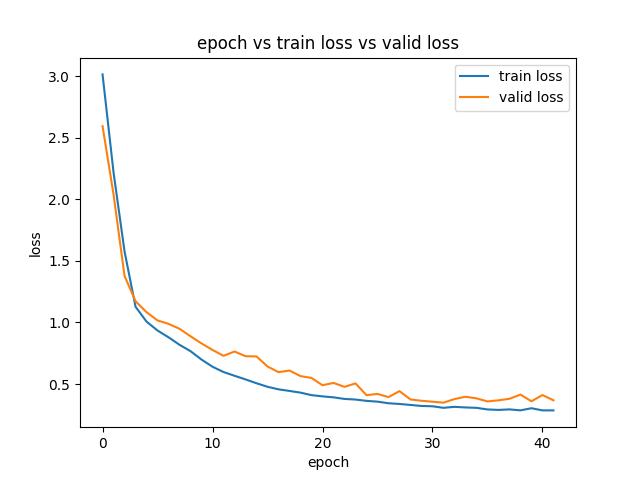

In [1]:
from IPython.display import Image
Image(filename='../output/hdfs/bert/train_valid_loss.png') 

In [12]:
# para finalizar o experimento, a inference usando o modelo criado;
# nessa etapa, usamos os 2 arquivos criados para teste (test_normal e test_abnormal), ambos com sequencias não utilizadas no treinamento;
# com isso, é possível verificar o desempenho do modelo criado, tanto quando um log é considerado normal ou anormal:

In [8]:
!python poc.py predict

device cuda
features logkey:True time: False

mask ratio 0.65
arguments Namespace(mean=0, std=1, mode='predict')
model_path: ../output/hdfs/bert/best_bert.pth
test normal predicting
553368it [00:05, 106058.71it/s]
/home/caf/projects/NLP/logbert/poc/../bert_pytorch/predict_log.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  log_seqs = np.array(log_seqs)
/home/caf/projects/NLP/logbert/poc/../bert_pytorch/predict_log.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tim_seqs = np.array(tim_seqs)
test_normal size: 553368
/home/caf/projects/NLP/

In [10]:
# o processo de inference acima gera artefatos (serializados) dos resultados no diretorios de output:

In [11]:
# tree output/
# output/
# └── hdfs
#     ├── bert
#     │   ├── best_bert.pth
#     │   ├── best_center.pt
#     │   ├── best_total_dist.pt
#     │   ├── parameters.txt
#     │   ├── test_abnormal_errors.pkl
#     │   ├── test_abnormal_results
#     │   ├── test_normal_errors.pkl
#     │   ├── test_normal_results
#     │   ├── train_log2.csv
#     │   ├── train_valid_loss.png
#     │   └── valid_log2.csv
#     ├── HDFS.log_structured.csv
#     ├── HDFS.log_templates.csv
#     ├── hdfs_log_templates.json
#     ├── hdfs_sequence.csv
#     ├── test_abnormal
#     ├── test_normal
#     ├── train
#     └── vocab.pkl